<a href="https://colab.research.google.com/github/alchua1996/MachineLearning/blob/master/Wavelet_Scattering_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
sns.set()

# Load Image

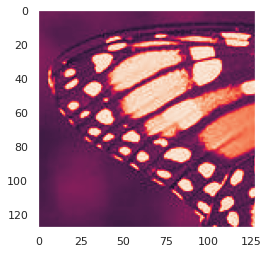

In [ ]:
# Load image and crop to make 128 x 128
img_orig = mpimg.imread('/content/drive/MyDrive/butterfly.jpg')
img = img_orig[44:172,44:172] / 255
plt.imshow(img)
plt.grid(False)

# Function to Calculate Each entry of Filter

In [ ]:
def L(r,j): #low pass
    if(2**j * r <= np.pi/2):
        out = 1
    elif(np.pi/2 <= 2**j * r <= np.pi):
        out = np.cos(np.pi/2 * np.log2(2* 2**(j) * r/np.pi))
    else:
        out = 0
    return out

def H(r,j): #high pass
    if(2**j * r <= np.pi/2):
        out = 0
    elif(np.pi/2 <= 2**j * r <= np.pi/4):
        out = np.cos(np.pi/2 * np.log2(2**(j) * r/np.pi))
    else:
        out = 1
    return out

def G_q(theta, Q,q): #directional cones
    alpha = 2**(Q - 1) * np.math.factorial(Q-1) / np.sqrt(Q*np.math.factorial(2*(Q-1)))
    r1 = theta - np.pi * q/Q
    if(r1 < -np.pi):
        r1 += 2*np.pi
    r2 = theta - np.pi * (q - Q)/Q
    if(r2 > np.pi):
        r2 -= 2*np.pi
    if(np.abs(r1) <= np.pi/2 and np.abs(r2) <= np.pi/2):
        out = np.cos(r1)**(Q-1) + np.cos(r2)**(Q-1)
    elif(np.abs(r1) <= np.pi/2 and np.abs(r2) > np.pi/2):
        out = np.cos(r1)**(Q-1)
    elif(np.abs(r1) > np.pi/2 and np.abs(r2) <= np.pi/2):
        out = np.cos(r2)**(Q-1)
    else:
        out = 0
    return alpha * out

# Convert to Polar

In [ ]:
def polar_grid(sample_rate_x, sample_rate_y): 
    grid = np.zeros((sample_rate_x,sample_rate_y,2), dtype = 'float')
    x = np.linspace(-np.pi, np.pi, num=sample_rate_x, endpoint=False)
    y = np.linspace(-np.pi, np.pi, num=sample_rate_y, endpoint=False)
    xx, yy = np.meshgrid(x, y, sparse=False, indexing='ij')
    rr = np.sqrt(xx**2 + yy**2)
    theta = np.arctan2(yy,xx)
    grid[:,:,0] = rr
    grid[:,:,1] = theta
    return grid 

In [ ]:
grid = polar_grid(100,100)

def L_grid(grid, J=0):
    N = grid.shape[0]
    M = grid.shape[1]
    L_matrix = np.zeros((N,M), dtype = 'float')
    for n in range(N):
        for m in range(M):
            L_matrix[n,m] = L(grid[n,m,0],J)
    return L_matrix

def H_grid(grid, j=0):
    N = grid.shape[0]
    M = grid.shape[1]
    H_matrix = np.zeros((N,M))
    for n in range(N):
        for m in range(M):
            H_matrix[n,m] = H(grid[n,m,0],j)
    return H_matrix

def G_grid(grid,Q):
    N = grid.shape[0]
    M = grid.shape[1]
    G_matrix = np.zeros((N,M,Q))
    for n in range(N):
        for m in range(M):
            for q in range(Q):
                G_matrix[n,m,q] = G_q(grid[n,m,1], Q, q)
    return G_matrix            

def psi_grid(grid, Q, J):
    N = grid.shape[0]
    M = grid.shape[1]
    psi_matrix = np.zeros((N,M,Q,J))
    G = G_grid(grid,Q)
    for j in range(J):
        L = L_grid(grid, j)
        H = H_grid(grid, j+1)
        for q in range(Q):
            psi_matrix[:,:,q,j] = G[:,:,q] * L * H     
    return psi_matrix

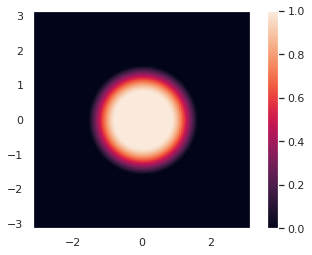

In [ ]:
L_mat = L_grid(grid, 1)
plt.imshow(L_mat, extent = [-np.pi, np.pi, -np.pi, np.pi])
plt.colorbar()
plt.grid(None)

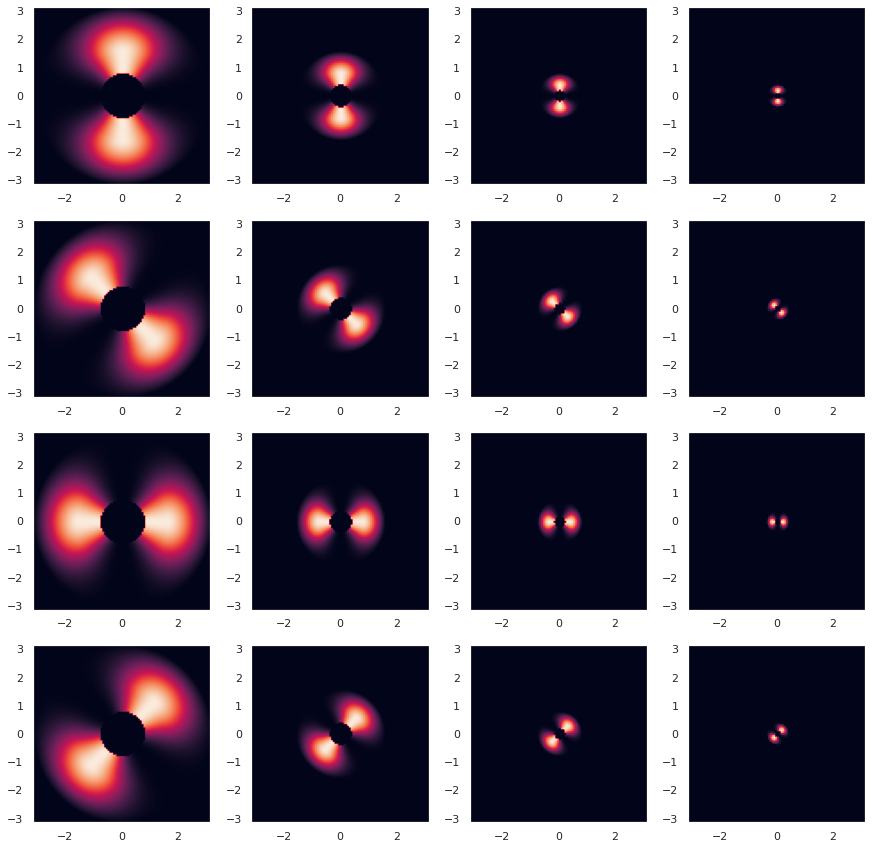

In [ ]:
psi_mat = psi_grid(grid,4,4)
c = 1
plt.figure(figsize = (15,15))
for j in range(4):
    for q in range(4):
        plt.subplot(4,4,c)
        plt.imshow(psi_mat[:,:,j,q], extent = [-np.pi, np.pi, -np.pi, np.pi])
        plt.grid(False)
        c = c+1

In [ ]:
def conv_frequency(img, filter):
    convolved_img = np.fft.ifft2(np.fft.fft2(img) * np.fft.fftshift(filter))
    return convolved_img

In [ ]:
def get_next_layer(coeffs,filters,num_angles, d):
    #current number of wavelet coefficients in coeffs array
    num_coeffs = num_angles**(d-1)
    N = coeffs.shape[0]
    count = 0
    if(d == 1):
        next_layer = np.zeros((N,N, num_angles), dtype = 'complex')
        for m in range(num_angles):
            next_layer[:,:,count] = conv_frequency(coeffs, filters[:,:,m])
            count += 1 
    else:
        next_layer = np.zeros((N,N, num_coeffs * num_angles), dtype = 'complex')
        count = 0
        for n in range(num_coeffs):
            for m in range(num_angles):
                next_layer[:,:,count] = conv_frequency(coeffs[:,:,n], filters[:,:,m])
                count += 1 
    return next_layer

In [ ]:
def wavelet_scattering_transform(img, psi, phi, num_angles, depth):
    #number of wavelet coefficients
    num_coeff = 0
    for n in range(depth+1):
        num_coeff += num_angles**n

    #wavelet coefficient index
    count = 0

    #initialize array to store all wavelet coefficients
    wavelet_coefficients = np.zeros((img.shape[0],img.shape[0],num_coeff), dtype = 'complex')

    for d in range(depth+1):
        if d == 0:
            curr_layer = img 
            wavelet_coefficients[:,:,count] = conv_frequency(curr_layer, phi)
            count+=1
        else: 
            next_layer = get_next_layer(curr_layer, psi[:,:,:,d-1], num_angles, d)
            next_layer = np.abs(next_layer)
            for n in range(num_angles**d):
                wavelet_coefficients[:,:,count] = conv_frequency(next_layer[:,:,n],phi)
                count += 1 
            curr_layer = next_layer        
    return wavelet_coefficients

In [ ]:
depth  = 2
num_angles = 4
grid = polar_grid(img.shape[0], img.shape[1])
psi = psi_grid(grid, num_angles, depth)
phi = L_grid(grid, depth)
scattering_coeff = wavelet_scattering_transform(img, psi, phi, num_angles, depth)
scattering_coeff = np.abs(scattering_coeff)

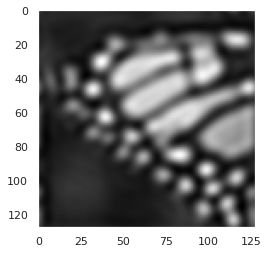

In [ ]:
plt.imshow(scattering_coeff[:,:,0], cmap = 'gray')
plt.grid(False)

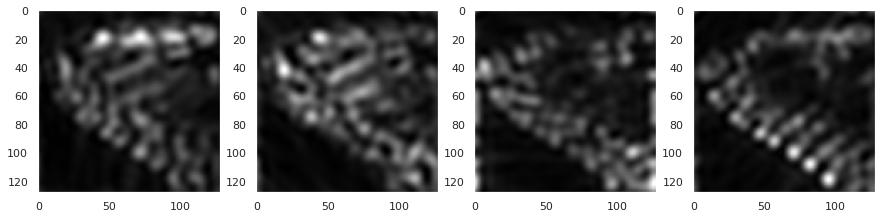

In [ ]:
c = 1
plt.figure(figsize = (15,4))
for j in range(num_angles):
    plt.subplot(1,num_angles,c)
    plt.imshow(scattering_coeff[:,:,j+1], cmap = 'gray')
    plt.grid(False)
    c = c+1

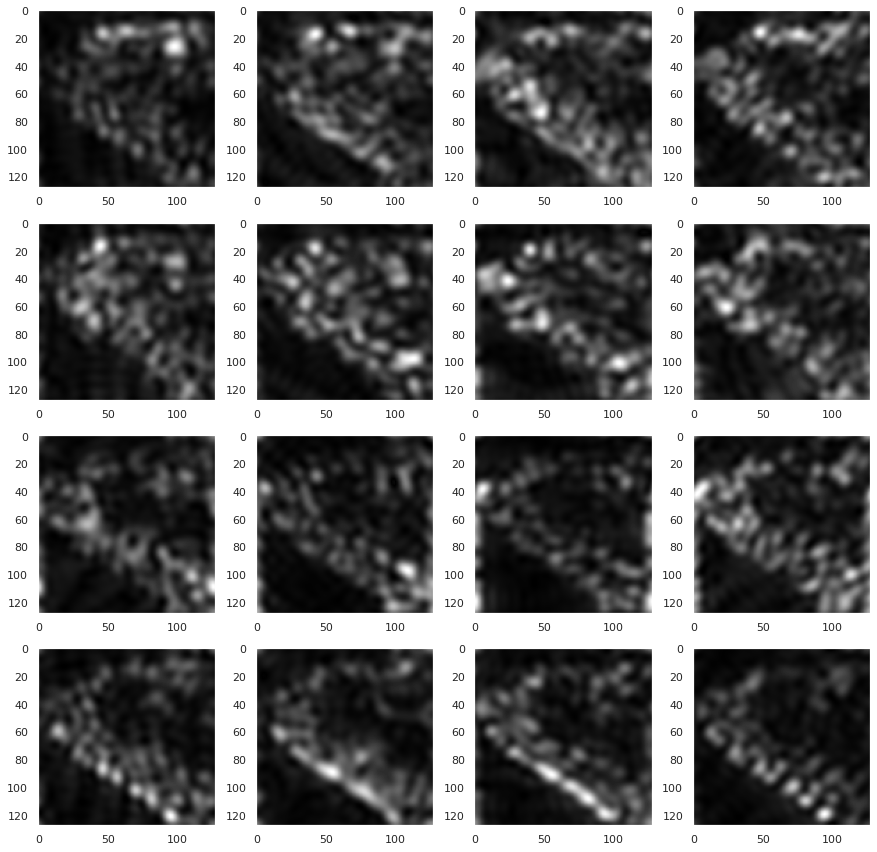

In [ ]:
c = 1
plt.figure(figsize = (15,15))
for j in range(num_angles**2):
    plt.subplot(4,num_angles,c)
    plt.imshow(scattering_coeff[:,:,5+j], cmap = 'gray')
    plt.grid(False)
    c = c+1

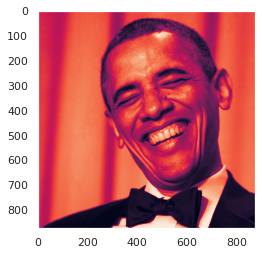

In [ ]:
# Load image and crop 
obama_orig = mpimg.imread('/content/drive/MyDrive/barack-obama-laughs.jpg')
obama = obama_orig[:874,:874,0] / 255
plt.imshow(obama)
plt.grid(False)

In [ ]:
depth = 2
num_angles = 4
grid = polar_grid(obama.shape[0], obama.shape[1])
psi = psi_grid(grid, num_angles, depth)
phi = L_grid(grid, depth)
obama_coeff = wavelet_scattering_transform(obama, psi, phi, num_angles, depth)

In [ ]:
obama_coeff = np.abs(obama_coeff)

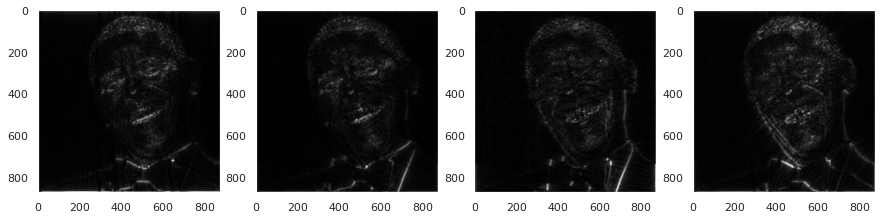

In [ ]:
c = 1
plt.figure(figsize = (15,4))
for j in range(num_angles):
    plt.subplot(1,num_angles,c)
    plt.imshow(obama_coeff[:,:,j+1], cmap = 'gray')
    plt.grid(False)
    c = c+1